# Analysis of Yelp Business Intelligence Data


We will analyze a subset of Yelp's business, reviews and user data. This dataset comes to us from [Kaggle](https://www.kaggle.com/yelp-dataset/yelp-dataset#yelp_academic_dataset_user.json). although we have taken steps to pull this data into a publis s3 bucket: s3://sta9760-spark-yelp/yelp-dataset/yelp_academic_dataset_business.json

## Installation and Initial Setup
LBegin by installing the necessary libraries that you may need to conduct your analysis. At the very least, you must install pandas and matplotlib

In [1]:
sc.install_pypi_package("pandas==1.0.3")

VBox()

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
0,application_1588558357705_0001,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [2]:
sc.install_pypi_package("matplotlib==3.2.1")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
sc.install_pypi_package( "IPython" )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

  Created wheel for backcall: filename=backcall-0.1.0-py3-none-any.whl size=10413 sha256=c18bf692da153a01063b04a6f05eeb49e74045ca12dd45d64e6cce1798a4ec5d
  Stored in directory: /mnt/var/lib/livy/.cache/pip/wheels/b4/cb/f1/d142b3bb45d488612cf3943d8a1db090eb95e6687045ba61d1
Successfully built backcall

In [4]:
sc.install_pypi_package( "seaborn==0.10.0" )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### Importing
Now, import the installed packages from the previous block below.

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

## Loading Data
We are finally ready to load data. Using spark load the data from S3 into a dataframe object that we can manipulate further down in our analysis.

In [6]:
yelp_b = spark.read.json( 's3://sta9760-spark-yelp/yelp-dataset/yelp_academic_dataset_business.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
yelp_t = spark.read.json('s3://sta9760-spark-yelp/yelp-dataset/yelp_academic_dataset_tip.json')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [8]:
type(yelp_b)
type(yelp_t)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

<class 'pyspark.sql.dataframe.DataFrame'>

## Overview of Data
Display the number of rows and columns in our dataset.

In [9]:
print( f'Total Columns: {len(yelp_b.columns)}' )
print(f'Total Rows: {yelp_b.count():,}')

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Total Columns: 14
Total Rows: 209,393

Display the DataFrame schema below.

In [10]:
yelp_b.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

Display the first 5 rows with the following columns:

* business_id
* name
* city
* state
* categories

In [11]:
yelp_b.select(['business_id','name','city','state','categories']).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+---------------+-----+--------------------+
|         business_id|                name|           city|state|          categories|
+--------------------+--------------------+---------------+-----+--------------------+
|f9NumwFMBDn751xgF...|The Range At Lake...|      Cornelius|   NC|Active Life, Gun/...|
|Yzvjg0SayhoZgCljU...|   Carlos Santo, NMD|     Scottsdale|   AZ|Health & Medical,...|
|XNoUzKckATkOD1hP6...|             Felinus|       Montreal|   QC|Pets, Pet Service...|
|6OAZjbxqM5ol29BuH...|Nevada House of Hose|North Las Vegas|   NV|Hardware Stores, ...|
|51M2Kk903DFYI6gnB...|USE MY GUY SERVIC...|           Mesa|   AZ|Home Services, Pl...|
+--------------------+--------------------+---------------+-----+--------------------+
only showing top 5 rows

# Analyzing Categories
Let's now answer this question: **how many unique categories are represented in this dataset?**

Essentially, we have the categories per business as a list - this is useful to quickly see what each business might be represented as but it is difficult to easily answer questions such as:

* How many businesses are categorized as *Active Life*, for instance
* What are the top 20 most popular categories available?

# Association Table
We need to "break out" these categories from the business ids? One common approach to take is to build an association table mapping a single business id multiple times to each distinct category.

For instance, given the following:


| business_id | categories |
|-------------|------------|
| abcd123     | a,b,c      |

We would like to derive something like:

| business_id | category |
|-------------|------------|
| abcd123     | a          |
| abcd123     | b          |
| abcd123     | c          |


What this does is allow us to then perform a myriad of rollups and other analysis on this association table which can aid us in answering the questions asked above.

Implement the code necessary to derive the table described from your original yelp dataframe.

In [12]:
yelp_b.select('categories').show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|          categories|
+--------------------+
|Active Life, Gun/...|
|Health & Medical,...|
|Pets, Pet Service...|
|Hardware Stores, ...|
|Home Services, Pl...|
|Auto Repair, Auto...|
|Dry Cleaning & La...|
|Auto Repair, Oil ...|
|Ethnic Food, Food...|
|Martial Arts, Gym...|
+--------------------+
only showing top 10 rows

In [13]:
from pyspark.sql.functions import split, explode

bus_split = yelp_b.select(yelp_b.business_id, explode(split(yelp_b.categories, ', '))\
                                       .alias('category'))

bus_split.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----------------+
|         business_id|        category|
+--------------------+----------------+
|f9NumwFMBDn751xgF...|     Active Life|
|f9NumwFMBDn751xgF...|Gun/Rifle Ranges|
|f9NumwFMBDn751xgF...|     Guns & Ammo|
|f9NumwFMBDn751xgF...|        Shopping|
|Yzvjg0SayhoZgCljU...|Health & Medical|
+--------------------+----------------+
only showing top 5 rows

## Total Unique Categories

Finally, we are ready to answer the question: **what is the total number of unique categories available?**

Below, implement the code necessary to calculate this figure.

In [14]:
bus_split.select('category').distinct().count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

1336

## Top Categories By Business
Now let's find the top categories in this dataset by rolling up categories.

### Counts of Businesses / Category
So now, let's unroll our distinct count a bit and display the per count value of businesses per category.

The expected output should be:

| category | count |
|-------------|------------|
| a     | 15         |
| b     | 2          |
| c     | 45          |


Or something to that effect.

In [15]:
bus_split.groupby('category').count().show(20)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+-----+
|           category|count|
+-------------------+-----+
|     Dermatologists|  341|
|   Historical Tours|   54|
|Mobile Home Dealers|   16|
|     Paddleboarding|   36|
|   Hot Air Balloons|   21|
|       Aerial Tours|   28|
|      Skating Rinks|  104|
|  Signature Cuisine|    1|
|             Fondue|   54|
|      Data Recovery|  195|
|  Pet Waste Removal|   34|
|      Videographers|  169|
|    Pet Photography|   49|
|        Boat Repair|  100|
|            Beaches|   74|
|       Contract Law|   13|
|        Hobby Shops|  828|
|           Day Spas| 2880|
|              Reiki|  312|
|Private Jet Charter|   10|
+-------------------+-----+
only showing top 20 rows

### Bar Chart of Top Categories
<p>With this data available, let us now build a barchart of the top 20 categories. <p>
HINT : don't forget about the matplotlib magic!
%matplot plt

### It would be great if we can see some data visually

In [16]:
descending = bus_split.groupby('category')\
                    .count()\
                    .orderBy(['count'], ascending = False)
descending.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+-----+
|     category|count|
+-------------+-----+
|  Restaurants|63944|
|     Shopping|34644|
|         Food|32991|
|Home Services|22487|
|Beauty & Spas|20520|
+-------------+-----+
only showing top 5 rows

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

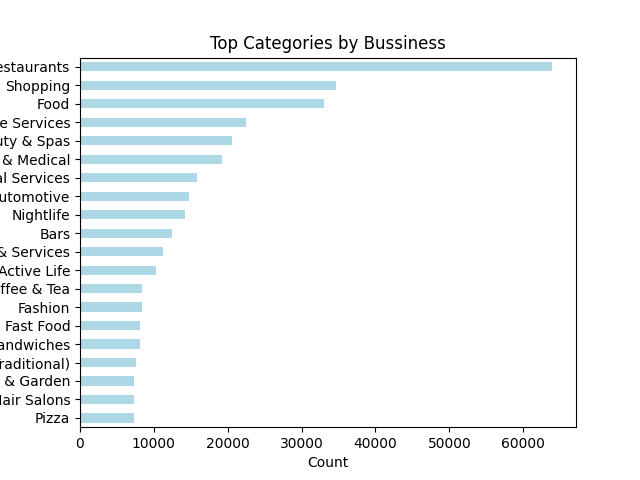

In [17]:
descending.toPandas()\
    .head(20)\
    .sort_values(ascending = True, by='count')\
    .plot.barh(y = 'count', 
               x = 'category', 
               rot=0, 
               title = 'Top Categories by Bussiness', 
               legend = False,
               color = 'lightblue')\
    .set(xlabel="Count", ylabel = 'Category')


%matplot plt

# Do Yelp Reviews Skew Negative?

Oftentimes, it is said that the only people who write a written review are those who are extremely dissatisfied or extremely satisfied with the service received.

How true is this really? Let's try and answer this question.

## Loading User Data
Begin by loading the user data set from S3 and printing schema to determine what data is available.

In [18]:
yelp_review  = spark.read.json( 's3://sta9760-spark-yelp/yelp-dataset/yelp_academic_dataset_review.json' )
yelp_user  = spark.read.json( 's3://sta9760-spark-yelp/yelp-dataset/yelp_academic_dataset_user.json' )

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [19]:
yelp_review.printSchema()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- business_id: string (nullable = true)
 |-- cool: long (nullable = true)
 |-- date: string (nullable = true)
 |-- funny: long (nullable = true)
 |-- review_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)
 |-- useful: long (nullable = true)
 |-- user_id: string (nullable = true)

In [20]:
yelp_review.select(['business_id','stars']).show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|         business_id|stars|
+--------------------+-----+
|-MhfebM0QIsKt87iD...|  2.0|
|lbrU8StCq3yDfr-QM...|  1.0|
|HQl28KMwrEKHqhFrr...|  5.0|
|5JxlZaqCnk1MnbgRi...|  1.0|
|IS4cv902ykd8wj1TR...|  4.0|
+--------------------+-----+
only showing top 5 rows

Now, let's aggregate along the stars column to get a resultant dataframe that displays average stars per business as accumulated by users who took the time to submit a written review.

In [21]:
from pyspark.sql.functions import avg

aggregate_average = yelp_review.filter(yelp_review.text.isNotNull())\
            .groupby(yelp_review.business_id)\
            .agg(avg(yelp_review.stars))

aggregate_average.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+------------------+
|         business_id|        avg(stars)|
+--------------------+------------------+
|ATeOjZzE3VOI-RW7F...| 3.433734939759036|
|RMjCnixEY5i12Ciqn...|3.5316455696202533|
|vbUABNAQI2iwN7v0x...|2.4545454545454546|
|VHsNB3pdGVcRgs6C3...| 3.411764705882353|
|r-W1HPIZ3V6S2DaXh...| 4.852459016393443|
+--------------------+------------------+
only showing top 5 rows

**Joining two dataframes**    
Now the fun part - let's join our two dataframes (reviews and business data) by business_id.

In [22]:
yelp_b.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['address', 'attributes', 'business_id', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state']

In [23]:
join_d = yelp_b\
                .join(aggregate_average, on=['business_id'], how='inner')
join_d.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['business_id', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state', 'avg(stars)']

Let's see a few of these:

In [24]:
join_d.select(['avg(stars)','stars','name','city','state'])\
            .orderBy('stars', ascending = False)\
            .show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+-----+--------------------+---------+-----+
|        avg(stars)|stars|                name|     city|state|
+------------------+-----+--------------------+---------+-----+
|4.7631578947368425|  5.0|Las Vegas Carpet ...|Las Vegas|   NV|
|               5.0|  5.0|                NEON|  Phoenix|   AZ|
|               5.0|  5.0|  702 Driving School|Henderson|   NV|
|               5.0|  5.0|         ITM Trading|  Phoenix|   AZ|
|              4.75|  5.0| Humble Root Organic|Newmarket|   ON|
+------------------+-----+--------------------+---------+-----+
only showing top 5 rows

Compute a new dataframe that calculates what we will call the _skew_ (for lack of a better word) between the avg stars accumulated from written reviews and the _actual_ star rating of a business (ie: the average of stars given by reviewers who wrote an actual review **and** reviewers who just provided a star rating).

The formula you can use is something like:

```
(row['avg(stars)'] - row['stars']) / row['stars']
```

If the **skew** is negative, we can interpret that to be: reviewers who left a written response were more dissatisfied than normal. If **skew** is positive, we can interpret that to be: reviewers who left a written response were more satisfied than normal.

In [25]:
skew = join_d.withColumn('skew',((join_d['avg(stars)'] - join_d['stars']) / join_d['stars']))\
            .select(['name','skew'])
skew.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+
|                name|                skew|
+--------------------+--------------------+
|     Dublin O'Neil's|-0.02521008403361...|
|     Four Star Sushi|0.009041591320072382|
|Los Vietnamita Ta...|-0.01010101010101019|
|   Rockland Trailers|                 0.0|
|       Allen Hui, OD|-0.02950819672131...|
+--------------------+--------------------+
only showing top 5 rows

In [26]:
skew_ = skew.select('skew').\
            toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

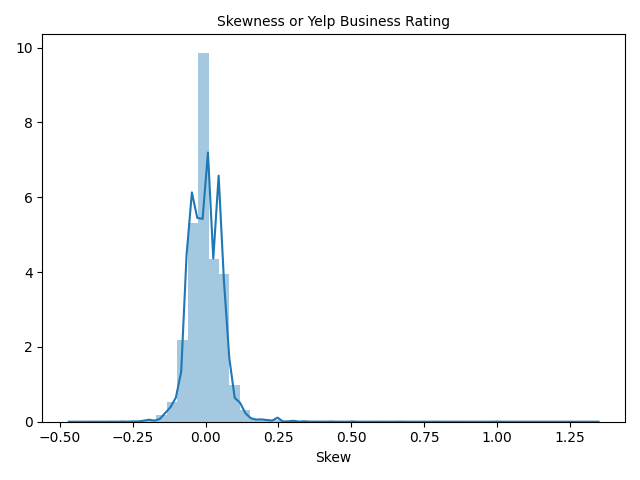

In [27]:
plt.figure()

ax = sb.distplot(skew_)

ax.set_xlabel('Skew', size=10)

plt.title("Skewness or Yelp Business Rating", size=10)

plt.tight_layout()

%matplot plt

# Should the Elite be Trusted?
### How accurate or close are the ratings of an "elite" user (check Users table schema) vs the actual business rating.

As someone who worked in a restaurant before I understand impact of Yelp reviews on business. I have always wondered if people who leave comments leave more reviews if they did't like the expirience or it didn't matter. My theory was that if they had great expirience they will just move on and tell their friends as well as come back again but might not leave a review. On the other hand someone who had bad expirience is more likely to leave a bad comment/review. There is another category of Yelp reviewers called "Elite". They would always get free food and drinks in oreder to promote restaurants. Servers also know who they are and thus give better service. It will be interesting to see if they are leaving better reviews than a regular person.

In [28]:
yelp_b.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['address', 'attributes', 'business_id', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state']

In [29]:
yelp_review.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['business_id', 'cool', 'date', 'funny', 'review_id', 'stars', 'text', 'useful', 'user_id']

In [30]:
yelp_user.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['average_stars', 'compliment_cool', 'compliment_cute', 'compliment_funny', 'compliment_hot', 'compliment_list', 'compliment_more', 'compliment_note', 'compliment_photos', 'compliment_plain', 'compliment_profile', 'compliment_writer', 'cool', 'elite', 'fans', 'friends', 'funny', 'name', 'review_count', 'useful', 'user_id', 'yelping_since']

Our elite useres are in yelp_user data set. We need to get them and combine it with yelp_b data set to look into how many stars they give.

In [31]:
from pyspark.sql.functions import explode,split

elite = yelp_user.select(yelp_user.user_id, explode(split(yelp_user.elite, ','))\
                        .alias('Year'))
                

elite.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+
|             user_id|Year|
+--------------------+----+
|ntlvfPzc8eglqvk92...|    |
|FOBRPlBHa3WPHFB5q...|2008|
|FOBRPlBHa3WPHFB5q...|2009|
|FOBRPlBHa3WPHFB5q...|2010|
|FOBRPlBHa3WPHFB5q...|2011|
+--------------------+----+
only showing top 5 rows

In [32]:
from pyspark.sql.functions import substring

reviews = yelp_review.select(
                   yelp_review.business_id,
                   yelp_review.user_id,
                   yelp_review.stars.alias('elite_rating'),
                   substring(yelp_review.date, 0,4).alias('Year')
                  )

reviews.show(5)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+--------------------+------------+----+
|         business_id|             user_id|elite_rating|Year|
+--------------------+--------------------+------------+----+
|-MhfebM0QIsKt87iD...|OwjRMXRC0KyPrIlcj...|         2.0|2015|
|lbrU8StCq3yDfr-QM...|nIJD_7ZXHq-FX8byP...|         1.0|2013|
|HQl28KMwrEKHqhFrr...|V34qejxNsCbcgD8C0...|         5.0|2015|
|5JxlZaqCnk1MnbgRi...|ofKDkJKXSKZXu5xJN...|         1.0|2011|
|IS4cv902ykd8wj1TR...|UgMW8bLE0QMJDCkQ1...|         4.0|2017|
+--------------------+--------------------+------------+----+
only showing top 5 rows

We are going to join this two with inner join by their id

In [33]:
elite_combined = elite.join(reviews, on = ['user_id','Year'], how = 'inner')
elite_combined.show(10)

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+--------------------+------------+
|             user_id|Year|         business_id|elite_rating|
+--------------------+----+--------------------+------------+
|-5uvOHRkvijt1vzSX...|2017|YWs-ZFQier0rFv1qa...|         4.0|
|-5uvOHRkvijt1vzSX...|2017|Lyzr1uckXL0U-iBoM...|         2.0|
|-5uvOHRkvijt1vzSX...|2017|IbOrNwCdMTd-eicZ9...|         3.0|
|-5uvOHRkvijt1vzSX...|2017|4vHm-szf4WUn77MbJ...|         3.0|
|-5uvOHRkvijt1vzSX...|2017|zBrm-ejSU0QwDlpFy...|         4.0|
|-6gYApoyPvez737nx...|2018|77h11eWv6HKJAgojL...|         4.0|
|-6gYApoyPvez737nx...|2018|nVAJZ6BJ9PPlxDXn9...|         4.0|
|-6gYApoyPvez737nx...|2018|QXV3L_QFGj8r6nWX2...|         4.0|
|-6gYApoyPvez737nx...|2018|0d0i0FaJq1GIeW1rS...|         4.0|
|-6gYApoyPvez737nx...|2018|mU3vlAVzTxgmZUu6F...|         3.0|
+--------------------+----+--------------------+------------+
only showing top 10 rows

In [34]:
rating_data = elite_combined.join(yelp_b, 
                  on = ['business_id'], 
                  how = 'inner')
rating_data.columns

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

['business_id', 'user_id', 'Year', 'elite_rating', 'address', 'attributes', 'categories', 'city', 'hours', 'is_open', 'latitude', 'longitude', 'name', 'postal_code', 'review_count', 'stars', 'state']

In [62]:
difference = rating_data.withColumn('difference in mean rating',rating_data['stars'] - rating_data['elite_rating'])
difference_count= difference.count()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
x = difference.select('difference in mean rating').toPandas()

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

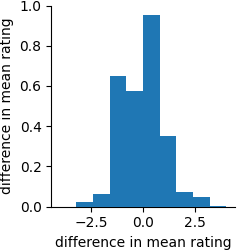

In [75]:
sb.pairplot(x)
%matplot plt

By the look on this graph, elite yelp reviewers are leaving higher ratings for the businesses like I suspected it would be. 